In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [ ]:
# Load the data
video_games_df = pd.read_csv('/content/Video_Games_Sales_as_at_22_Dec_2016.csv')

video_games_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Checking for missing values in relevant columns
missing_values = video_games_df[['Year_of_Release', 'Genre']].isnull().sum()

# Filtering the data for the years 1995 to 2016
video_games_df_filtered = video_games_df[(video_games_df['Year_of_Release'] >= 1995) &
                                         (video_games_df['Year_of_Release'] <= 2016)]

# Check the data type of 'Year_of_Release'
year_data_type = video_games_df_filtered['Year_of_Release'].dtype

missing_values, year_data_type

(Year_of_Release    269
 Genre                2
 dtype: int64,
 dtype('float64'))

In [ ]:
# Removing rows with missing Year_of_Release or Genre
video_games_cleaned = video_games_df_filtered.dropna(subset=['Year_of_Release', 'Genre'])

# Converting Year_of_Release from float to int
video_games_cleaned['Year_of_Release'] = video_games_cleaned['Year_of_Release'].astype(int)

# Check the cleaning results
cleaning_results = {
    'Rows After Cleaning': video_games_cleaned.shape[0],
    'Year_of_Release Data Type': video_games_cleaned['Year_of_Release'].dtype
}

cleaning_results

{'Rows After Cleaning': 15958, 'Year_of_Release Data Type': dtype('int64')}

In [ ]:
# Creating the pivot table for median sales by genre and year using our dataset
median_sales_pivot = video_games_cleaned.pivot_table(index='Year_of_Release',
                                                     columns='Genre',
                                                     values='Global_Sales',
                                                     aggfunc=np.median)

# Displaying the first few rows of the pivot table
median_sales_pivot.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year_of_Release,,,,,,,,,,,,
1995,0.380,0.050,0.230,0.085,0.300,0.175,0.155,0.340,0.100,0.085,0.190,0.125
1996,0.245,0.150,0.180,0.180,0.340,0.150,0.765,0.260,0.190,0.270,0.210,0.195
1997,0.240,0.145,0.250,0.235,0.310,0.260,0.290,0.400,0.130,0.320,0.490,0.280
1998,0.250,0.120,0.250,0.310,0.470,0.220,0.310,0.275,0.120,0.825,0.450,0.090
1999,0.400,0.140,0.155,0.400,0.465,0.075,0.300,0.450,0.335,0.325,0.315,0.215


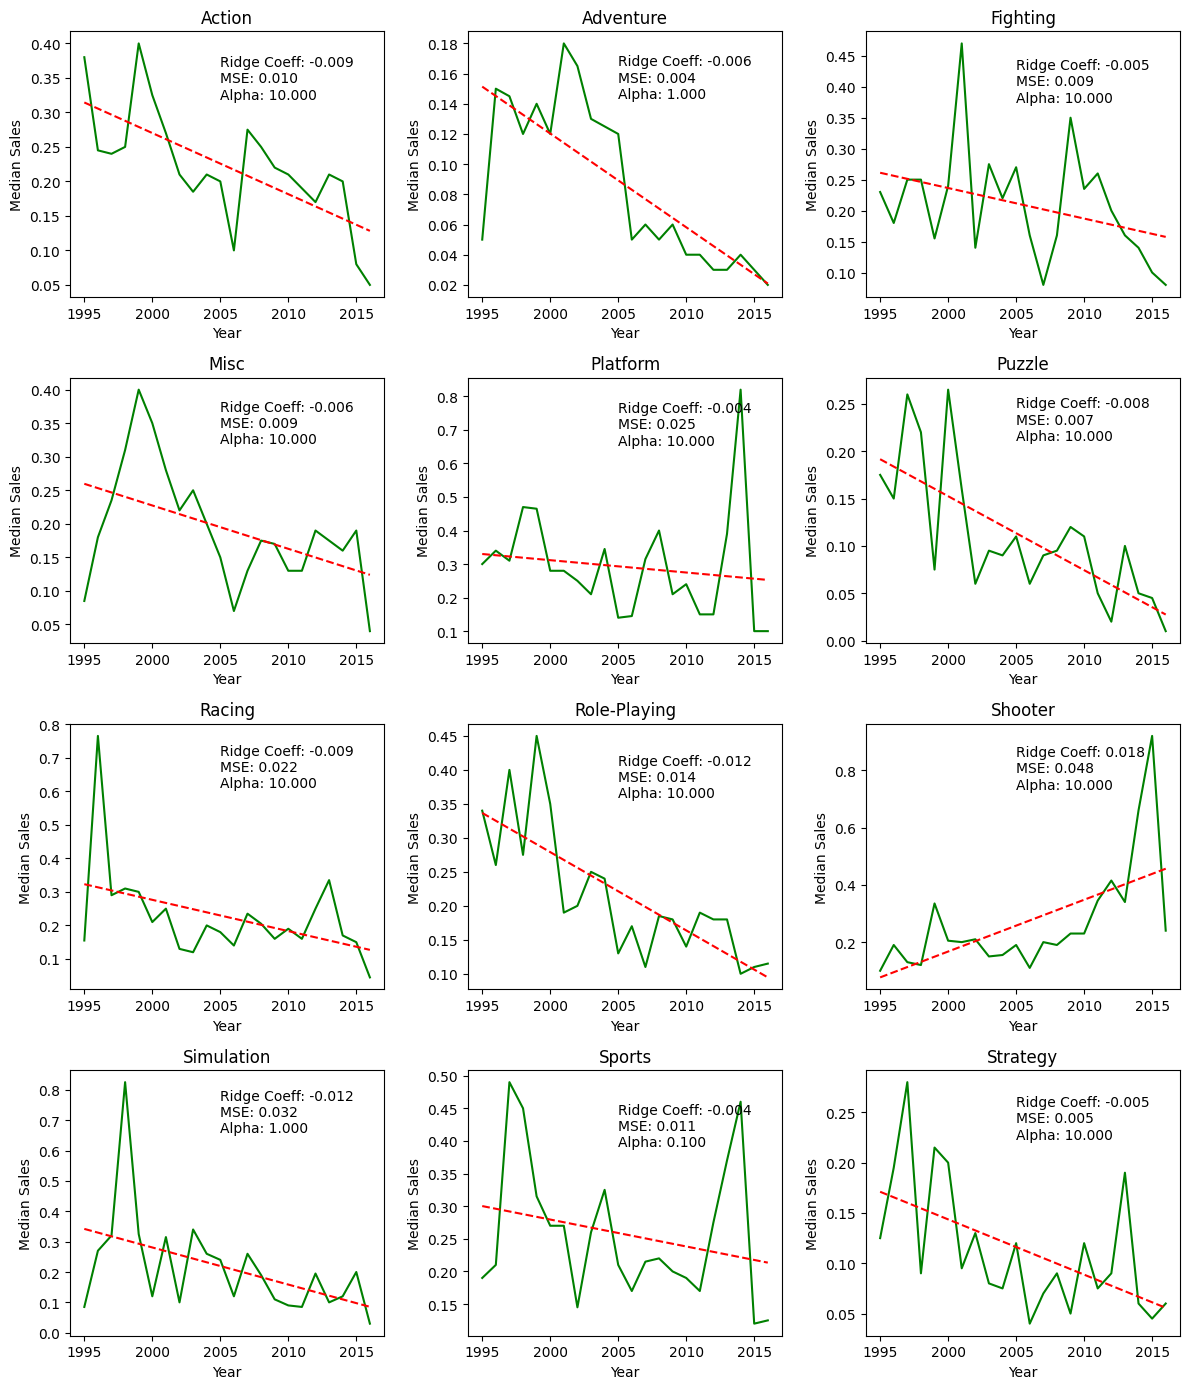

In [ ]:

def RidgeCV_Plot_Med_Data(Data):
    # Initialize lists for coefficients, MSE, and best alphas
    Ridge_Regr_Coeff = []
    Ridge_Regr_MSE = []
    Best_Alphas = []

    # Prepare figure for subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 14))
    axes = axes.flatten()

    # Loop through each genre
    for idx, genre in enumerate(Data.columns):
        # Ridge regression model with cross-validation
        x_data = np.asarray(Data.index).reshape(-1, 1)
        y_data = np.asarray(Data[genre].values).reshape(-1, 1)

        # Handling missing values for each genre
        valid_indices = ~np.isnan(y_data).flatten()
        x_data_clean = x_data[valid_indices]
        y_data_clean = y_data[valid_indices]

        model = RidgeCV(cv=5).fit(x_data_clean, y_data_clean.ravel())

        # Store the coefficient, MSE, and best alpha
        Ridge_Regr_Coeff.append(model.coef_[0])
        MSE = np.mean((model.predict(x_data_clean) - y_data_clean) ** 2)
        Ridge_Regr_MSE.append(MSE)
        Best_Alphas.append(model.alpha_)

        # Plotting
        axes[idx].plot(Data.index, Data[genre], color='green')
        axes[idx].plot(x_data_clean, model.predict(x_data_clean), color='red', linestyle='--')

        # Setting plot details
        axes[idx].set_title(genre)
        axes[idx].set_xlabel('Year')
        axes[idx].set_ylabel('Median Sales')
        axes[idx].text(2005, max(y_data_clean) * 0.8, f'Ridge Coeff: {Ridge_Regr_Coeff[idx]:.3f}\nMSE: {MSE:.3f}\nAlpha: {Best_Alphas[idx]:.3f}')

    plt.tight_layout()
    return [Ridge_Regr_Coeff, Ridge_Regr_MSE, Best_Alphas]

# Call the function with RidgeCV
[Ridge_Regr_Coeff, Ridge_Regr_MSE, Best_Alphas] = RidgeCV_Plot_Med_Data(median_sales_pivot)


In [ ]:
# Creating a DataFrame to display the coefficients, MSE, and best alpha for each genre using Lasso Regression results
ridge_genre_list = median_sales_pivot.columns
ridge_regression_results = pd.DataFrame({
    'Genre': ridge_genre_list,
    'Ridge Coefficient': Ridge_Regr_Coeff,
    'Ridge MSE': Ridge_Regr_MSE,
    'Alpha': Best_Alphas
})

# Sorting the results by ridge Coefficient in descending order
ridge_regression_results_sorted = ridge_regression_results.sort_values(by='Ridge Coefficient', ascending=False)
ridge_regression_results_sorted

,Genre,Ridge Coefficient,Ridge MSE,Alpha
8,Shooter,0.018071,0.048383,10.0
4,Platform,-0.003680,0.025302,10.0
10,Sports,-0.004127,0.011496,0.1
2,Fighting,-0.004933,0.008705,10.0
11,Strategy,-0.005491,0.005137,10.0
1,Adventure,-0.006213,0.004183,1.0
3,Misc,-0.006460,0.008995,10.0
5,Puzzle,-0.007811,0.007190,10.0
0,Action,-0.008861,0.009799,10.0
6,Racing,-0.009324,0.022059,10.0


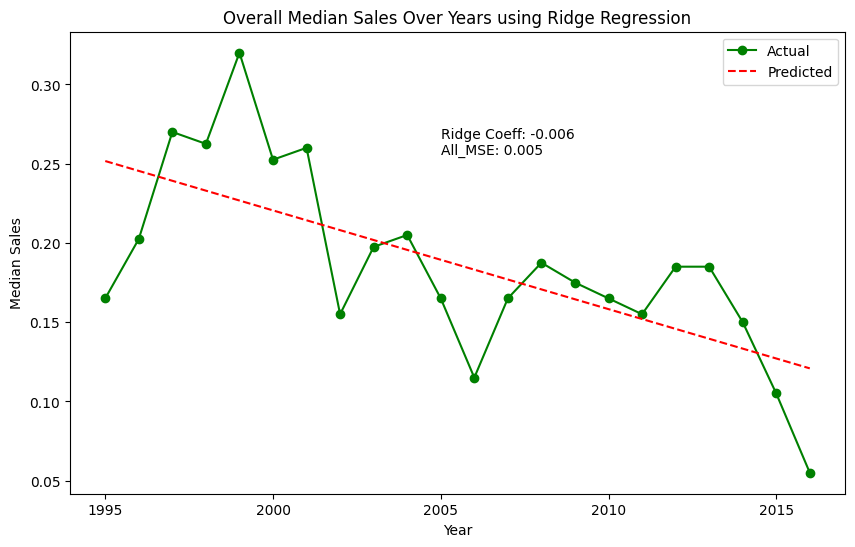

(-0.006229182411061663, 0.004988939900606935)

In [ ]:
def Ridge_Plot_Overall_Med_Sales(Data, alpha):
    # Aggregating median sales across genres for each year
    overall_median_sales = Data.median(axis=1)

    # Ridge regression model with best alpha
    x_data = np.asarray(overall_median_sales.index).reshape(-1, 1)
    y_data = np.asarray(overall_median_sales.values).reshape(-1, 1)

    model = Ridge(alpha=alpha)
    model.fit(x_data, y_data.ravel())

    # Store the coefficient and All_MSE
    Ridge_Coeff = model.coef_[0]
    All_MSE = np.mean((model.predict(x_data) - y_data) ** 2)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(overall_median_sales.index, overall_median_sales, color='green', marker='o', linestyle='-', label='Actual')
    plt.plot(overall_median_sales.index, model.predict(x_data), color='red', linestyle='--', label='Predicted')
    plt.title('Overall Median Sales Over Years using Ridge Regression')
    plt.xlabel('Year')
    plt.ylabel('Median Sales')
    plt.text(2005, max(y_data) * 0.8, f'Ridge Coeff: {Ridge_Coeff:.3f}\nAll_MSE: {All_MSE:.3f}')
    plt.legend()
    plt.show()

    return Ridge_Coeff, All_MSE

# Call the function with the best alpha for Ridge Regression
best_alpha = np.mean(Best_Alphas)  # Using the average of the best alphas found for each genre
Ridge_Coeff, All_MSE = Ridge_Plot_Overall_Med_Sales(median_sales_pivot, best_alpha)
Ridge_Coeff, All_MSE


In [ ]:
# Creating a DataFrame to display the results of the Ridge Regression for overall median sales
overall_lasso_results = pd.DataFrame({
    'Metric': ['Global Sales'],
    'Ridge Coefficient': [Ridge_Coeff],
    'Ridge MSE': [All_MSE],
    'Alpha': [best_alpha]
})

overall_lasso_results



,Metric,Ridge Coefficient,Ridge MSE,Alpha
0,Global Sales,-0.006229,0.004989,7.675
